In [ ]:
!pip install minisom
!pip install tensorflow

In [ ]:
import numpy as np
import pandas as pd
from minisom import MiniSom
# from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense, InputLayer

import tensorflow as tf
from keras import regularizers

from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as pt


In [ ]:
path = "/content/sample_data/indiancrop_dataset.csv"
path="/content/indiancrop_dataset.csv"

In [ ]:
df = pd.read_csv(path)
df

,N_SOIL,P_SOIL,K_SOIL,TEMPERATURE,HUMIDITY,ph,RAINFALL,STATE,CROP_PRICE,CROP
0,90,42,43,20.879744,82.002744,6.502985,202.935536,Andaman and Nicobar,7000,Rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,Andaman and Nicobar,5000,Rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,Andaman and Nicobar,7000,Rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,Andaman and Nicobar,7000,Rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,Andaman and Nicobar,120000,Rice
...,...,...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,West Bengal,1000,Coffee
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,West Bengal,800,Coffee
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,West Bengal,560,Coffee
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,West Bengal,1500,Coffee


In [ ]:
df[["RAINFALL"]].max(), df[["RAINFALL"]].min()

(RAINFALL    298.560117
 dtype: float64,
 RAINFALL    20.211267
 dtype: float64)

In [ ]:
X = df.iloc[:, :7].values
X = (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0))


labels = np.unique(df.iloc[:, 7].values, return_inverse=1)

Y = labels[1]
Y = (Y - np.min(Y, axis=0)) / (np.max(Y, axis=0) - np.min(Y, axis=0))


In [ ]:

le = LabelEncoder()
Y_encoded = le.fit_transform(labels[1])

Y_encoded

array([ 0,  0,  0, ..., 25, 25, 25])

In [ ]:
labs = le.fit_transform(df.iloc[:, 7])
labs == Y_encoded

array([ True,  True,  True, ...,  True,  True,  True])

In [ ]:
ms = MiniSom(x=10, y=10, input_len=X.shape[1], sigma=1.0, learning_rate=0.5)
ms.random_weights_init(X)

ms.train(data=X, num_iteration=100, verbose=True, random_order=True)

 [ 100 / 100 ] 100% - 0:00:00 left 
 quantization error: 0.16349594799605463


In [ ]:
ms._weights.shape

(10, 10, 7)

In [ ]:
# each neuron represents a cluster
winners = np.array([ms.winner(x) for x in X]).T

# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
clusters = np.ravel_multi_index(winners, (10, 10))

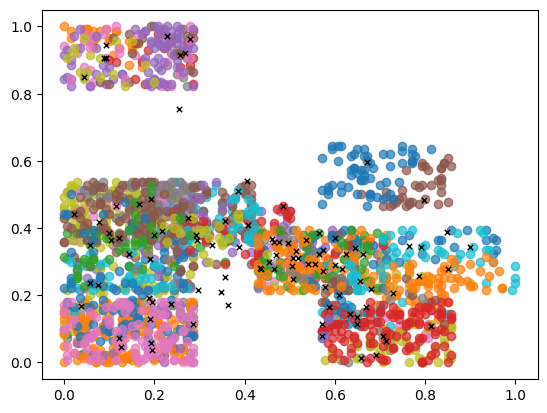

In [ ]:

%matplotlib inline

# plotting the clusters using the first 2 dimentions of the data
for c in np.unique(clusters):
    pt.scatter(
        X[clusters == c, 0],
        X[clusters == c, 1],
        label='cluster='+str(c),
        alpha=.7
    )

# plot centroids
for centroid in ms.get_weights():
    pt.scatter(
        centroid[:, 0],
        centroid[:, 1],
        marker='x',
        s=15,
        linewidths=1,
        color='k',
        label='centroid'
    )

# pt.legend()

In [ ]:
winners

array([[9, 0, 1, ..., 3, 3, 3],
       [6, 5, 5, ..., 6, 6, 6]])

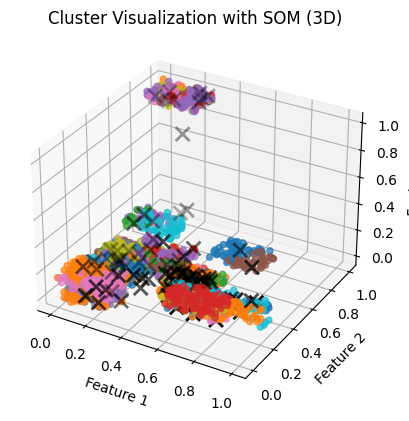

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = pt.figure()
ax = fig.add_subplot(111, projection='3d')

for c in np.unique(clusters):
    ax.scatter(
        X[clusters == c, 0],
        X[clusters == c, 1],
        X[clusters == c, 2],  
        # color=colors[c],
        label='cluster=' + str(c),
        alpha=0.7
    )

# Plot centroids (assuming 3 features)
for centroid in ms.get_weights():
    ax.scatter(
        centroid[:, 0],
        centroid[:, 1],
        centroid[:, 2],  
        marker='x',
        s=100,
        linewidths=2,
        color='k',
        label='centroid'
    )

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')  
ax.set_title('Cluster Visualization with SOM (3D)')
# pt.legend()
pt.show()


In [ ]:
len(X) == len(Y)

True

In [ ]:
ws = np.array([ms.winner(_) for _ in X])
ws

array([[9, 6],
       [0, 5],
       [1, 5],
       ...,
       [3, 6],
       [3, 6],
       [3, 6]])

In [ ]:
X[0]

array([0.64285714, 0.26428571, 0.19      , 0.34588614, 0.79026683,
       0.46626364, 0.65645778])

In [ ]:

input_size = 2
hidden_sizes = [64, 32]
output_size = len(np.unique(Y_encoded))
learning_rate = 0.05
l2_lambda = 0.01

# Define the model
model = Sequential()
model.add(InputLayer(input_shape=(input_size,)))

# Add hidden layers
for size in hidden_sizes:
    model.add(Dense(size, activation='relu'))
    kernel_regularizer=regularizers.l2(l2_lambda)


# Add output layer
model.add(tf.keras.layers.Dense(output_size, activation='softmax'))
# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
model.fit(ws, Y_encoded, epochs=1000, batch_size=32)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                192       
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 26)                858       
                                                                 
Total params: 3,130
Trainable params: 3,130
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
69/69 [==============================] - 1s 2ms/step - loss: 2.9122 - accuracy: 0.1818
Epoch 2/1000
69/69 [==============================] - 0s 2ms/step - loss: 2.5123 - accuracy: 0.2609
Epoch 3/1000
69/69 [==============================] - 0s 2ms/step - loss: 2.3994 - accuracy: 0.2618
Epoch 4/1000
69/

In [ ]:
predictions = model.predict(ws)

69/69 [==============================] - 0s 1ms/step


In [ ]:
predictions[0]

array([4.26076464e-02, 1.01794459e-01, 1.05238944e-01, 7.13437272e-04,
       5.39347582e-37, 1.00398576e-02, 4.59036743e-03, 5.15697114e-02,
       4.55821875e-21, 2.69575481e-04, 1.87245607e-02, 4.90132812e-03,
       1.51174814e-02, 8.61708634e-03, 4.56001632e-26, 4.18330627e-27,
       8.73886052e-07, 1.92553287e-07, 1.29918405e-03, 2.48533934e-02,
       1.91956609e-02, 0.00000000e+00, 0.00000000e+00, 4.40610588e-01,
       5.35459295e-02, 9.63098183e-02], dtype=float32)

In [ ]:
ad = df.iloc[:, 7].values

In [ ]:
c = 0

for i, v in enumerate(np.argmax(predictions, axis=1)):
    c += ad[i] == labels[0][v]
    print("{:<30} {}".format(ad[i], labels[0][v]))
    # print(labels[0][v])

Andaman and Nicobar            Uttar Pradesh
Andaman and Nicobar            Assam
Andaman and Nicobar            Assam
Andaman and Nicobar            Assam
Andaman and Nicobar            Assam
Andaman and Nicobar            Assam
Andaman and Nicobar            Assam
Andaman and Nicobar            Assam
Andaman and Nicobar            Assam
Andaman and Nicobar            Uttar Pradesh
Andaman and Nicobar            Assam
Andaman and Nicobar            Assam
Andaman and Nicobar            Assam
Andaman and Nicobar            Uttar Pradesh
Andaman and Nicobar            Assam
Andhra Pradesh                 Uttar Pradesh
Andhra Pradesh                 Assam
Andhra Pradesh                 Uttar Pradesh
Andhra Pradesh                 Assam
Andhra Pradesh                 Assam
Andhra Pradesh                 Uttar Pradesh
Andhra Pradesh                 Assam
Assam                          Uttar Pradesh
Assam                          Assam
Assam                          Assam
Assam              

In [ ]:
c / len(predictions)

0.7286363636363636